
# A simple Darcy-Flow spectrum analysis
Using ``neuralop.utils.spectrum_2d`` to perform spectrum analysis function on our small Darcy-Flow example.

For more details on spectrum analysis, users can take a look at this reference: https://www.astronomy.ohio-state.edu/ryden.1/ast825/ch7.pdf

## Short summary
Spectral analysis is useful because it allows researchers to study the distribution of energy across different scales in a fluid flow. 
The energy spectrum is analysed through the Fourier transform, a mathematical tool that decomposes a function or signal into its 
constituent frequencies. In a fluid flow, it is used to analyze the distribution of energy across different scales in a flow. 

Specifically, the Fourier transform is applied to the velocity field of the flow, converting it into a frequency domain representation. 
Higher the wavenumber corresponds to higher frequency and higher energy and is a much harder task to solve as we need higher modes to capture 
the high-frequency behavior of the flow. Overall this allows researchers to study the energy spectrum, which provides insights into the behavior 
of turbulence and the underlying physical processes.


In [1]:
# Original Author: Zongyi Li
# Modified by: Robert Joseph George

## Import dependencies
We first import our `neuralop` library and required dependencies.



In [1]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from neuralop.utils import spectrum_2d
from neuralop.data.datasets import load_darcy_flow_small

font = {'size'   : 28}
matplotlib.rc('font', **font)

torch.manual_seed(0)
np.random.seed(0)

/Users/reza/Career/DMLab/SURROGATE/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Define some variables



In [2]:
T = 500 # number of time steps
samples = 50
s = 16 # resolution of the dataset

# additional paramaters for the dataset
Re = 5000
index = 1
T = 100
dataset_name = "Darcy Flow"

Loading the Navier-Stokes dataset in 128x128 resolution



In [4]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=50, batch_size=50, 
        test_resolutions=[16, 32], n_tests=[50, 50],
        test_batch_sizes=[32], 
        encode_output=False
)

# This is highly depending on your dataset and its structure ['x', 'y'] (In Darcy flow)
print("Original dataset shape", train_loader.dataset[:samples]['x'].shape) # check the shape

# It is important to note that we want the last two dimensions to represent the spatial dimensions
# So in some cases one might have to permute the dataset after squeezing the initial dimensions as well
dataset_pred = train_loader.dataset[:samples]['x'].squeeze() # squeeze the dataset to remove the empty channel dimension

# Shape of the dataset
shape = dataset_pred.shape

# Define the grid size - in our case its a 2d Grid repeating, for higher dimensions this will change
# Example for 3d grid
"""
batchsize, size_x, size_y, size_z = 1, shape[0], shape[1], shape[2]
gridx = torch.tensor(np.linspace(-1, 1, size_x), dtype=torch.float)
gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
gridy = torch.tensor(np.linspace(-1, 1, size_y), dtype=torch.float)
gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
gridz = torch.tensor(np.linspace(-1, 1, size_z), dtype=torch.float)
gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
grid = torch.cat((gridx, gridy, gridz), dim=-1)
"""
batchsize, size_x, size_y = 1, shape[1], shape[2]
gridx = torch.tensor(np.linspace(-1, 1, size_x), dtype=torch.float)
gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, size_y])
gridy = torch.tensor(np.linspace(-1, 1, size_y), dtype=torch.float)
gridy = gridy.reshape(1, 1, size_y).repeat([batchsize, size_x, 1])
grid = torch.cat((gridx, gridy), dim=-1)

Loading test db for resolution 16 with 50 samples 
Loading test db for resolution 32 with 50 samples 
Original dataset shape torch.Size([50, 1, 16, 16])


### ## FFT plot



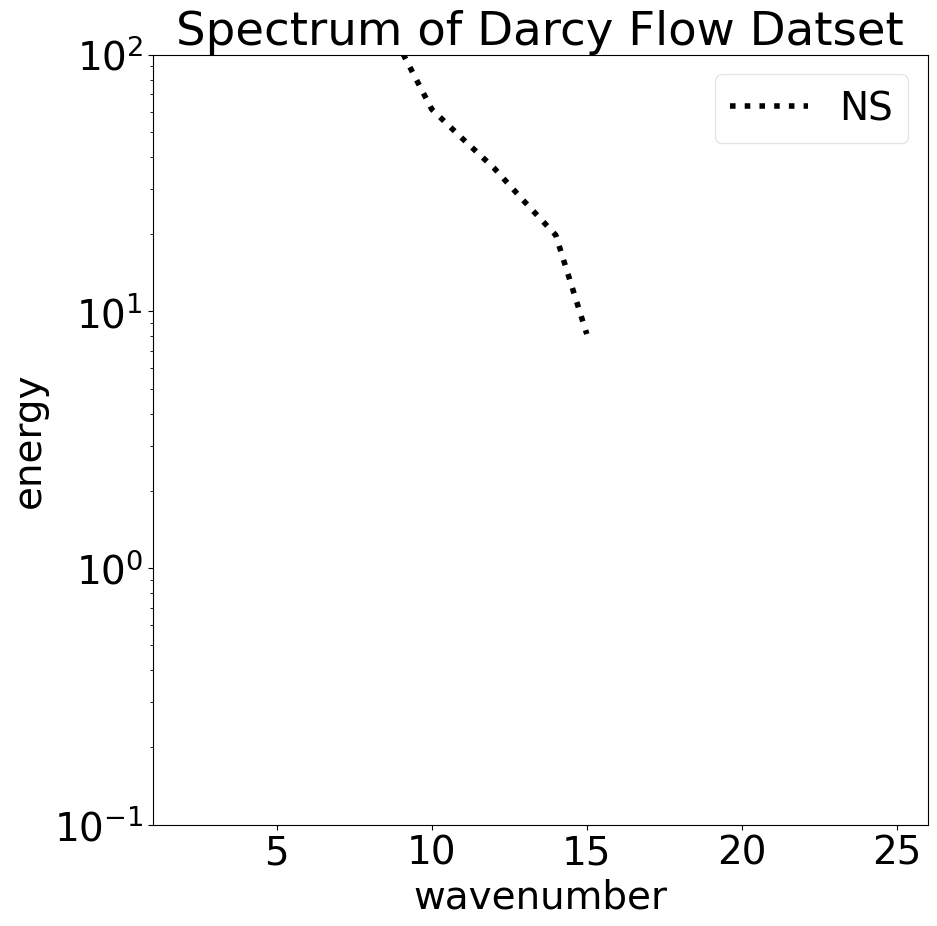

In [5]:
# Generate the spectrum of the dataset
# We reshape our samples into the form expected by ``spectrum_2d``: ``(n_samples, h, w)``
truth_sp = spectrum_2d(dataset_pred.reshape(samples * batchsize, s, s), s)

# Configure pyplot and generate the plot
fig, ax = plt.subplots(figsize=(10,10))

linewidth = 3
ax.set_yscale('log')

length = dataset_pred.shape[-1] # the resolution length of the dataset
buffer = 10 # just add a buffer to the plot
k = np.arange(length + buffer) * 1.0
ax.plot(truth_sp, 'k', linestyle=":", label="NS", linewidth=4)

ax.set_xlim(1,length+buffer)
ax.set_ylim(0.1, 100)
plt.legend(prop={'size': 20})
plt.title('Spectrum of {} Datset'.format(dataset_name))

plt.xlabel('wavenumber')
plt.ylabel('energy')

# show the figure
leg = plt.legend(loc='best')
leg.get_frame().set_alpha(0.5)
plt.show()